In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import external functions from the functions folder
import sys
sys.path.append('../../functions')
import functions as f

# Import pytorch libraries for the MLP
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Set local path to the folder containing the .wav audio files
path = 'C:/Users/lucvo/VScode/Machine_learning/Audio_data/nsynth-valid.jsonwav/nsynth-valid/audio/'

In [21]:
# Generate the dataset
X, y = f.generate_mixed_spectrograms(5000, 3, path=path)

# Flatten the data
X = X.reshape(X.shape[0], -1)

# Split into training, validation and test (80/10/10)
X_train, X_val, X_test, y_train, y_val, y_test = f.split_data(X, y, 0.1, 0.1)

100%|██████████| 5000/5000 [00:27<00:00, 179.23it/s]


In [22]:
# Convert to pytorch tensors and scale the data to be between 0 and 1
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Scale the data to be between 0 and 1
def torch_min_max_normalization(X):
    X = (X - X.min()) / (X.max() - X.min())
    return X

X_train = torch_min_max_normalization(X_train)
X_val = torch_min_max_normalization(X_val)
X_test = torch_min_max_normalization(X_test)

In [51]:
input_shape = X_train[0].shape
training_shape = input_shape[0]
print(training_shape)
num_classes = len(y[0])

# Define the MLP model, taking an input of the shape of the training data and outputting a probability for each class (num_class = 6)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(training_shape, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x
    
# Initialize the model
model = MLP()

# Define the loss function and optimizer
# Loss function is the sum of the differences between the predicted and actual classes
def criterion(y_pred, y_true):
    return torch.sum((y_pred - y_true) ** 2)/y_pred.shape[0]

def get_accuracy(y_pred, y_true):
    # Round the predictions to the nearest integer
    y_pred = torch.round(y_pred)
    # Calculate the accuracy
    return (y_pred == y_true).float().mean()
  
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training function
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=300, patience=5):
    # Initialize lists to store the loss and accuracy
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    # Loop through the epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(X_train)
        # Print the first prediction and actual class as numpy arrays
        predict = y_pred[0].detach().numpy()
        # Print with 2 decimal places
        print(np.round(predict, 2))
        print(y_train[0].detach().numpy())
        # Calculate the loss
        loss = criterion(y_pred, y_train)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Append the loss to the list
        train_loss.append(loss.item())
        # Calculate the accuracy
        accuracy = get_accuracy(y_pred, y_train)
        # Append the accuracy to the list
        train_accuracy.append(accuracy)

        # Set the model to evaluation mode
        model.eval()
        # Forward pass
        y_pred_val = model(X_val)
        # Calculate the loss
        loss = criterion(y_pred_val, y_val)
        # Append the loss to the list
        val_loss.append(loss.item())
        # Calculate the accuracy
        accuracy = get_accuracy(y_pred_val, y_val)
        # Append the accuracy to the list
        val_accuracy.append(accuracy)

        # Print the epoch, training loss and accuracy, and validation loss and accuracy
        print(f'Epoch: {epoch}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.4f}')
        print()

        # Include an early stopping mechanism 
        if epoch > patience:
            if val_loss[-patience] <= min(val_loss):
                print(f'Early stopping: Validation loss has not decreased for the last {patience} epochs')
                break
        

    return train_loss, val_loss, train_accuracy, val_accuracy, model, y_pred, y_pred_val

129150


In [52]:
# Train the model
train_loss, val_loss, train_accuracy, val_accuracy, trained_model, last_y_pred, last_y_pred_val = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=300)

[0.07 0.   0.11 0.02 0.05 0.08]
[0 0 1 1 0 1]
Epoch: 0, Training Loss: 2.7063, Training Accuracy: 0.5000, Validation Loss: 2.4750, Validation Accuracy: 0.5000

[0.15 0.   0.1  0.1  0.15 0.1 ]
[0 0 1 1 0 1]
Epoch: 1, Training Loss: 2.4815, Training Accuracy: 0.5000, Validation Loss: 2.3065, Validation Accuracy: 0.4990

[0.22 0.02 0.09 0.15 0.22 0.21]
[0 0 1 1 0 1]
Epoch: 2, Training Loss: 2.3118, Training Accuracy: 0.4997, Validation Loss: 2.1563, Validation Accuracy: 0.4960

[0.28 0.08 0.1  0.21 0.27 0.33]
[0 0 1 1 0 1]
Epoch: 3, Training Loss: 2.1592, Training Accuracy: 0.4933, Validation Loss: 2.0420, Validation Accuracy: 0.4927

[0.34 0.14 0.12 0.26 0.31 0.46]
[0 0 1 1 0 1]
Epoch: 4, Training Loss: 2.0413, Training Accuracy: 0.4880, Validation Loss: 1.9644, Validation Accuracy: 0.4993

[0.4  0.21 0.17 0.31 0.36 0.56]
[0 0 1 1 0 1]
Epoch: 5, Training Loss: 1.9597, Training Accuracy: 0.4910, Validation Loss: 1.9148, Validation Accuracy: 0.5060

[0.46 0.25 0.23 0.36 0.41 0.62]
[0 0 1 1

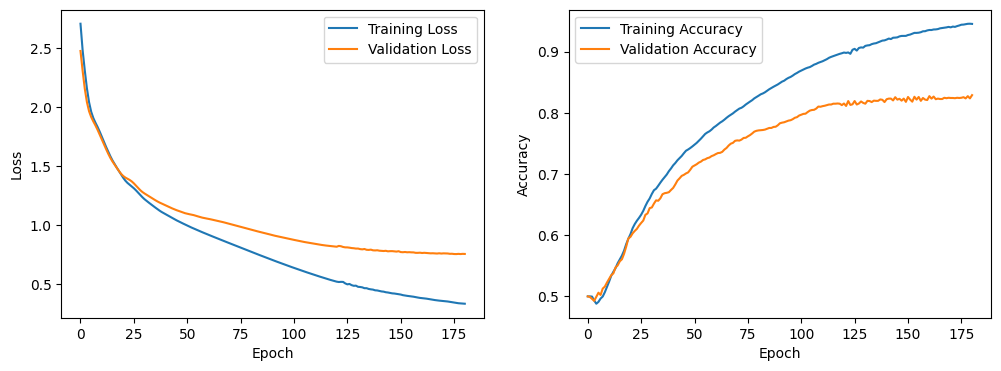

In [53]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [57]:
print(last_y_pred)
print(y_train)
print(last_y_pred_val)
print(y_val)

tensor([[0.0000, 0.0797, 0.8642, 1.0074, 0.0557, 0.7950],
        [0.8319, 0.9375, 0.0000, 0.0000, 0.0000, 0.9243],
        [0.0420, 0.4635, 0.7501, 0.9240, 0.0000, 0.2831],
        ...,
        [1.0195, 0.7629, 0.6289, 0.0000, 0.0000, 0.3701],
        [0.8078, 0.0000, 0.4162, 1.0910, 0.2991, 0.1807],
        [0.6667, 0.3743, 0.9930, 0.0000, 0.1225, 0.1045]],
       grad_fn=<ReluBackward0>)
tensor([[0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 0],
        ...,
        [1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 0, 0],
        [1, 1, 1, 0, 0, 0]])
tensor([[0.0710, 0.9375, 1.1063, 0.0000, 0.0326, 1.2817],
        [0.0000, 0.5266, 0.4275, 0.9693, 1.1236, 0.0456],
        [0.1090, 0.9428, 0.1037, 0.7291, 0.0000, 0.9998],
        ...,
        [1.0831, 0.3872, 1.0888, 0.0000, 0.2747, 0.0000],
        [0.8782, 0.1120, 0.0000, 0.0848, 0.8627, 0.7674],
        [0.9256, 0.3457, 0.5530, 0.0000, 0.9419, 0.1496]],
       grad_fn=<ReluBackward0>)
tensor([[0, 1, 1, 0, 0, 1],
  

In [58]:
# Save the model
torch.save(trained_model, 'MLP_multi_inst_class.pth')